## __VAE__

参考：PyTorchの[example](https://github.com/pytorch/examples/blob/main/vae/main.py)

In [5]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
image_size = 28*28
h_dim = 400
z_dim = 20
num_epochs = 10
batch_size = 128
learning_rate = 1e-3

# Dataset
dataset = torchvision.datasets.MNIST(
    root=".",
    transform=torchvision.transforms.ToTensor(),
    download=True
)

# DataLoader
data_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=batch_size, 
    shuffle=True
)

#### __VAEクラスの実装__

Encoderは平均 $μ$ と 分散の対数 $\log{\sigma^2}$ を出力する。

分散 $\sigma^2$ を出力する場合は、出力値が正でなければならないため、深層学習では出力しづらい。

そこで、分散の対数 $\log{\sigma^2}$ という値域が実数全体の値を出力している。

In [7]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super().__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc21 = nn.Linear(h_dim, z_dim)
        self.fc22 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        self.fc4 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h1 = nn.ReLU()(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = nn.ReLU()(self.fc3(z))
        return nn.Sigmoid()(self.fc4(h3))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [8]:
model = VAE().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# 学習
for epoch in range(num_epochs):
    epoch_loss = 0
    for x, _ in tqdm(data_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        bce_loss = F.binary_cross_entropy(x_reconst, x, reduction="sum")
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = bce_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss
        losses.append((loss / len(x)).item())
    
    epoch_loss /= len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs} Loss : {epoch_loss}")

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/10 Loss : 164.65237426757812


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/10 Loss : 121.75764465332031


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/10 Loss : 114.87140655517578


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/10 Loss : 111.78596496582031


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/10 Loss : 109.98100280761719


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6/10 Loss : 108.85565948486328


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7/10 Loss : 107.92683410644531


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8/10 Loss : 107.2303237915039


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9/10 Loss : 106.70030975341797


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10/10 Loss : 106.23588562011719


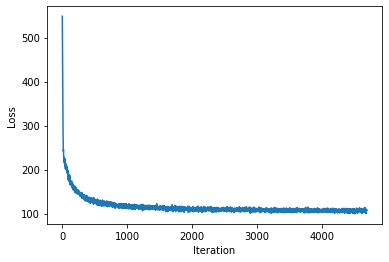

In [9]:
# 学習曲線
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

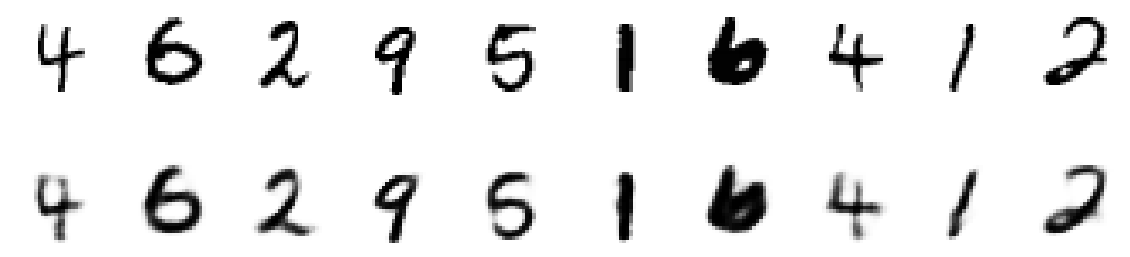

In [10]:
# 上段に元の画像、下段に生成画像を表示
model.eval()
with torch.no_grad():
    x, _ = next(iter(data_loader))
    x = x.to(device).view(-1, image_size)
    x_reconst, _, _ = model(x)
    x_reconst = x_reconst.view(-1, 28, 28).detach().cpu().numpy()
x = x.view(-1, 28, 28).cpu()

num_images = 10
plt.figure(figsize=(20, 5))
for i in range(num_images):
    plt.subplot(2, num_images, i+1)
    plt.imshow(x[i], cmap="gray_r")
    plt.axis("off")

    plt.subplot(2, num_images, i+1+num_images)
    plt.imshow(x_reconst[i], cmap="gray_r")
    plt.axis("off")
plt.show()

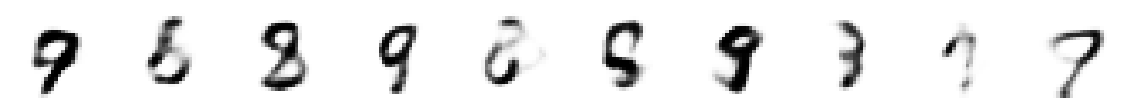

In [11]:
# ノイズから画像を生成
model.eval()
with torch.no_grad():
    z = torch.randn(batch_size, z_dim).to(device)
    outputs = model.decode(z).view(-1, 28, 28).detach().cpu().numpy()

num_images = 10
plt.figure(figsize=(20, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(outputs[i], cmap="gray_r")
    plt.axis("off")
plt.show()